# Data Cleaning

In [2]:
import pandas as pd
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [3]:
data = pd.read_csv('data/owid-co2-data.csv')
df = data
print(df.shape)
df.head()

(24016, 38)


,iso_code,country,year,co2,co2_growth_prct,co2_growth_abs,consumption_co2,trade_co2,trade_co2_share,co2_per_capita,consumption_co2_per_capita,share_global_co2,cumulative_co2,share_global_cumulative_co2,co2_per_gdp,consumption_co2_per_gdp,co2_per_unit_energy,cement_co2,coal_co2,flaring_co2,gas_co2,oil_co2,cement_co2_per_capita,coal_co2_per_capita,flaring_co2_per_capita,gas_co2_per_capita,oil_co2_per_capita,total_ghg,ghg_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,primary_energy_consumption,energy_per_capita,energy_per_gdp,population,gdp
0,AFG,Afghanistan,1949,0.015,NaN,NaN,NaN,NaN,NaN,0.002,NaN,0.000,0.015,0.000,NaN,NaN,NaN,0.0,0.015,0.0,0.0,0.000,0.0,0.002,0.0,0.0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7663783.0,NaN
1,AFG,Afghanistan,1950,0.084,475.000,0.070,NaN,NaN,NaN,0.011,NaN,0.001,0.099,0.001,0.004,NaN,NaN,0.0,0.022,0.0,0.0,0.066,0.0,0.003,0.0,0.0,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7752000.0,1.949480e+10
2,AFG,Afghanistan,1951,0.092,8.696,0.007,NaN,NaN,NaN,0.012,NaN,0.001,0.191,0.001,0.005,NaN,NaN,0.0,0.026,0.0,0.0,0.066,0.0,0.003,0.0,0.0,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7840000.0,2.006385e+10
3,AFG,Afghanistan,1952,0.092,0.000,0.000,NaN,NaN,NaN,0.012,NaN,0.001,0.282,0.001,0.004,NaN,NaN,0.0,0.033,0.0,0.0,0.062,0.0,0.004,0.0,0.0,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7936000.0,2.074235e+10
4,AFG,Afghanistan,1953,0.106,16.000,0.015,NaN,NaN,NaN,0.013,NaN,0.002,0.388,0.001,0.005,NaN,NaN,0.0,0.037,0.0,0.0,0.066,0.0,0.005,0.0,0.0,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8040000.0,2.201546e+10


In [3]:
#Only include data from 1950 and later
df = df[df['year']>=1950]

In [4]:
#Drop columns with >8K null values (50% of data)
df.dropna(axis=1,thresh=8000, inplace=True)


In [5]:
#Drop continents, identified by lacking an ISO code
df.dropna(axis=0,subset=['iso_code'],inplace=True)

#Drop "World" entries
df = df[df.country != 'World']
df.shape

(14404, 19)

<BarContainer object of 221 artists>

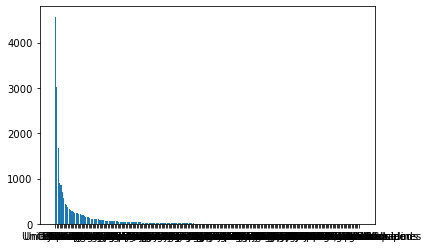

In [6]:
#Visualize total CO2 emissions by country (note: fix size to make more legible)
import matplotlib.pyplot as plt
plt.bar(x=df.groupby(['country'])['co2'].mean().sort_values(ascending=False).index,height=df.groupby(['country'])['co2'].mean().sort_values(ascending=False))


In [7]:
#Look at top 50 total CO2 emission values by country to determine cut-off point

df.groupby(['country'])['co2'].mean().sort_values(ascending=False)[:50]

country
United States           4572.443145
China                   3020.410884
Russia                  1678.672633
Germany                  907.555435
Japan                    862.353855
India                    711.136391
United Kingdom           562.317333
Ukraine                  431.599350
Canada                   408.196348
France                   380.734435
Italy                    323.503725
Poland                   315.624159
South Africa             273.030304
Mexico                   263.238609
Australia                239.099464
South Korea              239.019536
Iran                     238.637420
Brazil                   208.254638
Saudi Arabia             207.846739
Spain                    191.898884
Kazakhstan               190.311700
Indonesia                178.857464
Turkey                   143.218507
Czechia                  140.431083
Netherlands              139.889377
Taiwan                   117.495261
Belgium                  111.949609
Romania             

In [8]:
#Create df of top 10 CO2 emmiters per capita, of the top 22 total CO2 emmiters
#Cut off at 22 after Indonesia above due to local dropoff point
top22_co2 = list(df.groupby(['country'])['co2'].mean().sort_values(ascending=False)[:22].index)
df_top22_co2 = df.loc[df['country'].isin(top22_co2)]
top10_percapita = list(df_top22_co2.groupby(['country'])['co2_per_capita'].mean().sort_values(ascending=False)[:10].index)
print(top10_percapita)


['United States', 'Canada', 'Australia', 'Kazakhstan', 'Russia', 'Germany', 'Saudi Arabia', 'United Kingdom', 'Poland', 'Ukraine']


# Time Series Model for USA

In [11]:
#Reload original df to get pre-1950 USA data
df_USA = data

#Only include USA co2_per_capita data post-1800 (lacking data before this date)
df_USA = df_USA[df_USA['year'] >= 1800]
df_USA = df_USA[df_USA['country'] == 'United States']
df_USA = df_USA[['year','co2_per_capita']]
df_USA.set_index('year', inplace=True)

print(df_USA.shape)
df_USA.head()

(219, 1)


,co2_per_capita
year,
1800,0.037
1801,0.039
1802,0.041
1803,0.041
1804,0.045


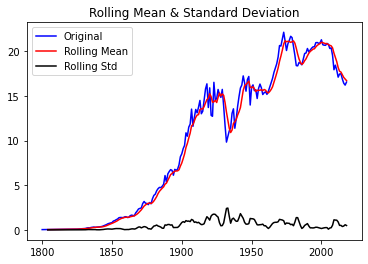

In [12]:
roll_mean = df_USA.rolling(window=5, center=False).mean()
roll_std = df_USA.rolling(window=5, center=False).std()

plt.plot(df_USA,color='blue', label='Original')
plt.plot(roll_mean, color='red', label='Rolling Mean')
plt.plot(roll_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [13]:
# REMOVAL NOTE: no need to difference for ARIMA
#ARIMA Model
#get differenced values
diff = df_USA.diff().rename(index=str, columns={"co2_per_capita": "Differenced Observations"})


**Dickey-Fuller Test**

In [14]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(diff['Differenced Observations'][1:-1])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
dfoutput

##NOTE: small p-value (.001) indicates stationarity

Test Statistic                  -4.055314
p-value                          0.001147
#Lags Used                      11.000000
Number of Observations Used    205.000000
dtype: float64

**Checking out ACF/PACF to determine which terms in include**

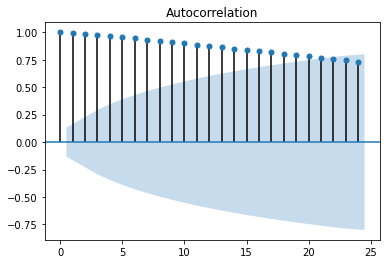

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df_USA[:-1], alpha=.05);

##NOTE: lag of 1,2,3 (and maybe 4) are significant
##NOTE: data is geometric! (indicates AR)

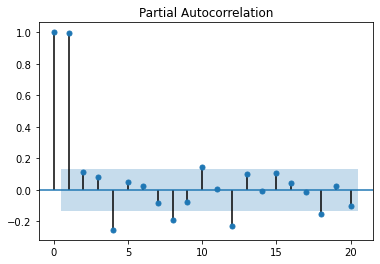

In [20]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df_USA[:-1], alpha=.05, lags=20);

##NOTE: lag of 1 is significant

NOTES:
- p/AR terms - check out PACF
- d/differencing - 1 or 2?
- q/MA terms - check out ACF

(1,2,3): arL1=0.000, maL1=0.002, maL2=0.000, maL3=0.000


insignificant: (1,1,3), (0,1,3), (0,2,3), (0,2,4), (1,2,4), (1,1,4), (0,1,2), (0,1,4), (5,2,3), (5,2,2), (5,1,3)

# Train-Test Split

In [77]:
#Split 95% of data into train set and 5% into test set
train = df_USA.loc[:2007]
test = df_USA.loc[2008:]

X_train, X_test = train.index , test.index
y_train, y_test = train['co2_per_capita'] , test['co2_per_capita']


# Fitting ARIMA Model
- order=(3,1,1) | L1=0.032, L2=0.141, L3=0.001 <--- same
- order=(3,1,0) | L1=0.032, L2=0.141, L3=0.001 <--- same
- order=(3,2,0) | L1=0.000, L2=0.000, L3=0.016
- order=(4,2,0) | L1=0.000, L2=0.000, L3=0.000, L4=0.006 <--- BEST
- order=(5,2,0) | L1=0.000, L2=0.000, L3=0.006, L4=0.000, L5=0.003 <--- ????
- order=(1,2,3) | arL1=0.000, maL1=0.002, maL2=0.000, maL3=0.000
- NOT AS GOOD: (4,1,0), (4,1,1), (20,1,1), (19,1,1)
- ERROR: (20,2,1), (20,2,2), (19,2,2), (19,2,1), (16,2,1)


Not sure between (4,2,0), (5,2,0), (1,2,20), (1,2,19), (1,1,19)


In [78]:
from statsmodels.tsa.arima_model import ARIMA

#fit model
mod123 = ARIMA(y_train[:-1], order=(1,2,3)) # p,d,q
mod123_fit = mod123.fit(disp=0)
print(mod123_fit.summary())
##NOTE: Check out coef and p-value - 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                             ARIMA Model Results                              
Dep. Variable:      D2.co2_per_capita   No. Observations:                  205
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -236.492
Method:                       css-mle   S.D. of innovations              0.756
Date:                Wed, 27 Jan 2021   AIC                            484.984
Time:                        12:58:06   BIC                            504.922
Sample:                             2   HQIC                           493.048
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0003      0.001      0.363      0.717      -0.001       0.002
ar.L1.D2.co2_per_capita    -0.7585      0.106     -7.147      0.000      -0.967      -0.551


In [79]:
pred = mod123_fit.predict(start=2008, end=2018, dynamic=False)


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


ValueError: Length of passed values is 1812, index implies 11.

In [58]:
from statsmodels.tsa.arima_model import ARIMA

#fit model
mod123 = ARIMA(df_USA[:-1], order=(1,2,3)) # p,d,q
mod123_fit = mod123.fit(disp=0)
print(mod123_fit.summary())
##NOTE: Check out coef and p-value - 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                             ARIMA Model Results                              
Dep. Variable:      D2.co2_per_capita   No. Observations:                  216
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -249.331
Method:                       css-mle   S.D. of innovations              0.761
Date:                Wed, 27 Jan 2021   AIC                            510.663
Time:                        12:34:05   BIC                            530.915
Sample:                             2   HQIC                           518.845
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0006      0.001     -0.425      0.671      -0.003       0.002
ar.L1.D2.co2_per_capita    -0.7431      0.113     -6.549      0.000      -0.965      -0.521


In [59]:
#fit model
mod420 = ARIMA(df_USA[:-1], order=(1,2,3)) # p,d,q
mod420_fit = mod420.fit(disp=0)
print(mod420_fit.summary())
##NOTE: Check out coef and p-value - 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                             ARIMA Model Results                              
Dep. Variable:      D2.co2_per_capita   No. Observations:                  216
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -249.331
Method:                       css-mle   S.D. of innovations              0.761
Date:                Wed, 27 Jan 2021   AIC                            510.663
Time:                        12:34:37   BIC                            530.915
Sample:                             2   HQIC                           518.845
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0006      0.001     -0.425      0.671      -0.003       0.002
ar.L1.D2.co2_per_capita    -0.7431      0.113     -6.549      0.000      -0.965      -0.521


In [60]:
#fit model
mod520 = ARIMA(df_USA[:-1], order=(1,2,3)) # p,d,q
mod520_fit = mod520.fit(disp=0)
print(mod520_fit.summary())
##NOTE: Check out coef and p-value - 

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                             ARIMA Model Results                              
Dep. Variable:      D2.co2_per_capita   No. Observations:                  216
Model:                 ARIMA(1, 2, 3)   Log Likelihood                -249.331
Method:                       css-mle   S.D. of innovations              0.761
Date:                Wed, 27 Jan 2021   AIC                            510.663
Time:                        12:34:58   BIC                            530.915
Sample:                             2   HQIC                           518.845
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0006      0.001     -0.425      0.671      -0.003       0.002
ar.L1.D2.co2_per_capita    -0.7431      0.113     -6.549      0.000      -0.965      -0.521


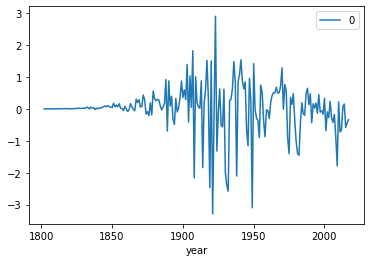

In [61]:
# Visualize residuals/error
residuals_123 = pd.DataFrame(mod123_fit.resid)
residuals_123.plot()
pyplot.show()


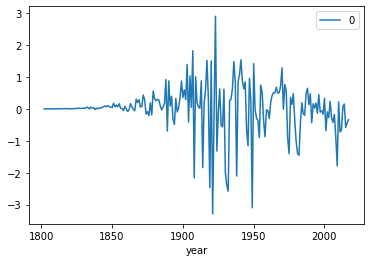

In [63]:
residuals_420 = pd.DataFrame(mod420_fit.resid)
residuals_420.plot()
pyplot.show()

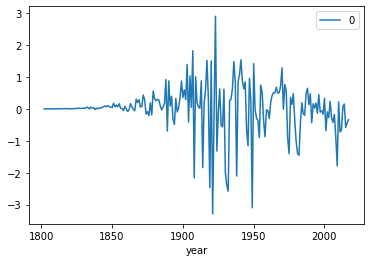

In [62]:
residuals_520 = pd.DataFrame(mod520_fit.resid)
residuals_520.plot()
pyplot.show()

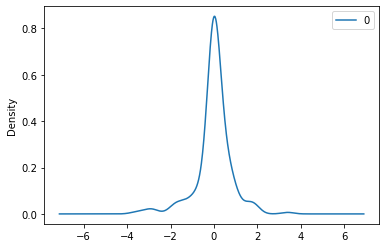

In [53]:
#what is this?? is this to check for linearity?
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde')
pyplot.show()

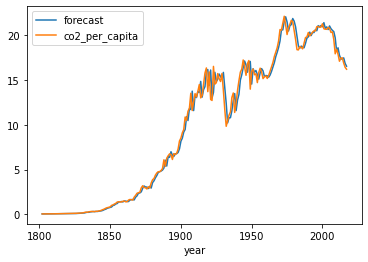

In [67]:
mod123_fit.plot_predict();


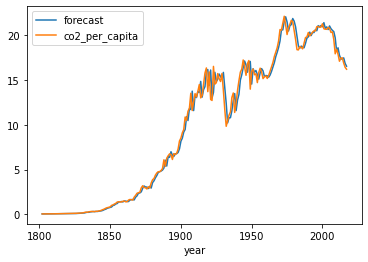

In [68]:
mod420_fit.plot_predict();


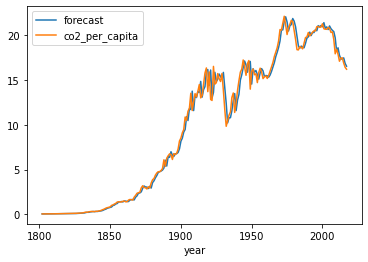

In [69]:
mod520_fit.plot_predict();


# Train-Test Split

In [75]:
#Split 95% of data into train set and 5% into test set
train = df_USA.loc[:2007]
test = df_USA.loc[2008:]

X_train, X_test = train.index , test.index
y_train, y_test = train['co2_per_capita'] , test['co2_per_capita']


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


ValueError: Length of passed values is 1801, index implies 11.

In [60]:
model_fit.forecast()[0] # 0 indicates the very next value the model predicts??


array([15.92231091])

## Next step: assess model with RMSE

In [ ]:
#choose top 50 countries by co2 emissions (not per capita)
#time series based on co2 emissions (not per capita)
#observe per capita data via visualizations

**Tuesday**

-Initial time series model (check for stationarity/trends, fix if not)--top 10 countries (not per capita)

-Vizualizations for top 10 countries per capita

**Wednesday**

-Fix whatever needs fixing

-Other EDA/visualizations

-Tune final model

**Thursday**

-Tune final model (if not done by Wed)

-Create Read Me, PPT presentation

-Clean up code

-Practice presentation

**Stretch Goals**

-Research peaks and valleys historically

-Compare to world emissions


In [ ]:
for country in top10_percapita:
    